In [3]:
import os
import glob
import yaml
import cv2

import importlib

import _pickle as pkl

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import seaborn as sns
import pylab as pl

In [234]:
import plotting as putil
import dlc as dlc

In [235]:
plot_style='dark'
putil.set_sns_style(style=plot_style)
bg_color='w' if plot_style=='dark' else 'k'

In [148]:
%matplotlib notebook

In [5]:
# import sys
# !conda install --yes --prefix {sys.prefix} tables

In [6]:
rootdir = '/mnt/minerva/courtship-free-behavior/maDLCv2' #maDLCv2'
projectname = 'MMFv2'

experiment = 'MF-20mm-cantons-RL'
projectdir = os.path.join(rootdir, projectname) 

# load config file
cfg_fpath = os.path.join(projectdir, 'config.yaml')
with open(cfg_fpath, "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

# get list of tracked files
srcdir = os.path.join(projectdir, experiment)
suffix = 'el_IDcorrected'
tracked_files = glob.glob(os.path.join(srcdir, '*', '*_{}.h5'.format(suffix)))
print(len(tracked_files))

13


In [264]:
fn = tracked_files[0]
curr_figid = os.path.splitext(os.path.split(fn)[-1])[0]

print(fn)

/mnt/minerva/courtship-free-behavior/maDLCv2/MMFv2/MF-20mm-cantons-RL/MF_030122_3/030122_Canton-S_age5_m_sh_f_gh_3DLC_dlcrnetms5_MMFv2Sep27shuffle1_200000_el_IDcorrected.h5


In [8]:
df0 = pd.read_hdf(fn)
df0.head()

In [10]:
df0.xs('ind1', level='individuals', axis=1)

scorer    DLC_dlcrnetms5_MMFv2Sep27shuffle1_200000                        
bodyparts                                  headTop                        
coords                                           x         y likelihood   
0                                          818.259  1094.121        1.0  \
1                                          824.415  1086.117        1.0   
2                                          824.547  1081.190        1.0   
3                                          826.187  1076.055        1.0   
4                                          833.067  1075.237        1.0   
...                                            ...       ...        ...   
15113                                          NaN       NaN        1.0   
15114                                          NaN       NaN        1.0   
15115                                          NaN       NaN        1.0   
15116                                          NaN       NaN        1.0   
15117                                          NaN       NaN        1.0   

scorer                                                                        
bodyparts thoraxCenter                      abdomenTop                        
coords               x         y likelihood          x         y likelihood   
0              760.900  1078.966      1.000    739.500  1075.218      1.000  \
1              767.248  1076.957      1.000    747.451  1071.435      1.000   
2              767.096  1072.299      1.000    749.076  1070.026      1.000   
3              771.710  1070.204      1.000    751.130  1065.949      1.000   
4              776.409  1071.546      1.000    753.440  1067.496      1.000   
...                ...       ...        ...        ...       ...        ...   
15113          476.047   315.294      1.000    452.012   346.961      0.987   
15114          482.752   324.337      0.995    484.598   323.493      0.931   
15115          476.171   324.612      0.853    454.922   345.779      0.802   
15116          477.521   328.313      0.878    482.701   323.704      0.710   
15117          484.047   330.397      0.952    455.702   341.973      0.918   

scorer                   ...                                            
bodyparts abdomenCenter  ... hindlegLeft hindlegRightJoint1             
coords                x  ...  likelihood                  x         y   
0               707.038  ...         1.0            679.550  1094.314  \
1               713.780  ...         1.0            681.432  1095.734   
2               716.217  ...         1.0            687.485  1096.777   
3               715.125  ...         1.0            693.917  1097.394   
4               716.815  ...         1.0            723.799  1099.669   
...                 ...  ...         ...                ...       ...   
15113           461.067  ...         1.0            476.725   408.115   
15114           461.923  ...         1.0            476.395   410.913   
15115           461.329  ...         1.0            474.599   409.047   
15116           460.158  ...         1.0            473.946   407.776   
15117           459.908  ...         1.0            484.018   392.635   

scorer                                                                      
bodyparts            hindlegRightJoint2                      hindlegRight   
coords    likelihood                  x         y likelihood            x   
0                1.0            646.173  1090.464        1.0      585.665  \
1                1.0            647.076  1088.990        1.0      585.871   
2                1.0            651.587  1092.158        1.0      586.960   
3                1.0            656.688  1089.030        1.0      600.999   
4                1.0            689.187  1109.429        1.0      635.558   
...              ...                ...       ...        ...          ...   
15113            1.0                NaN       NaN        1.0          NaN   
15114            1.0                NaN       NaN

In [11]:
# def get_segment_indices(bodyparts2connect, all_bpts):
#     '''
#     https://github.com/DeepLabCut/DeepLabCut/blob/main/deeplabcut/utils/make_labeled_video.py
#     '''
#     bpts2connect = []
#     for bpt1, bpt2 in bodyparts2connect:
#         if bpt1 in all_bpts and bpt2 in all_bpts:
#             bpts2connect.extend(
#                 zip(
#                     *(
#                         np.flatnonzero(all_bpts == bpt1),
#                         np.flatnonzero(all_bpts == bpt2),
#                     )
#                 )
#             )
#     return bpts2connect

In [236]:
bodyparts2connect = cfg["skeleton"]

# if bodyparts2connect:
#     all_bpts = df0.columns.get_level_values("bodyparts")[::3]
#     inds_og  = get_segment_indices(bodyparts2connect, all_bpts)

bodyparts2plot = set(df0.columns.get_level_values("bodyparts"))
individuals = set(df0.columns.get_level_values("individuals"))

n_bodyparts = len(np.unique(df0.columns.get_level_values("bodyparts")[::3]))
print(n_bodyparts)
all_bpts = df0.columns.get_level_values("bodyparts")[::3][0:n_bodyparts]

29


In [237]:
# original indices specified in cfg file:
inds_og  = dlc.get_segment_indices(bodyparts2connect, all_bpts)
# create a skeleton connector for abdomen only
abdomen_pts = ['abdomenTop', 'abdomenLeft', 'abdomenLowerLeft', 'genitalia', 'abdomenLowerRight', 'abdomenRight']
abdomen_pts_tmp = abdomen_pts.copy()
abdomen_pts_tmp.append(abdomen_pts[0])
abdomen2connect = [[v, abdomen_pts_tmp[i+1]] for i, v in enumerate(abdomen_pts_tmp[0:-1])]
# get indices
inds_ab = dlc.get_segment_indices(abdomen2connect, all_bpts)

In [238]:
# colors = visualization.get_cmap(len(bodyparts2plot), name=cfg["colormap"])
pcutoff=0.01
animal_colors={'ind1': 'm', 'ind2': 'c'}
alphavalue=1
skeleton_edges=bodyparts2connect
skeleton_color=bg_color
bg_color

'w'

#### plot 1 frame

<IPython.core.display.Javascript object>


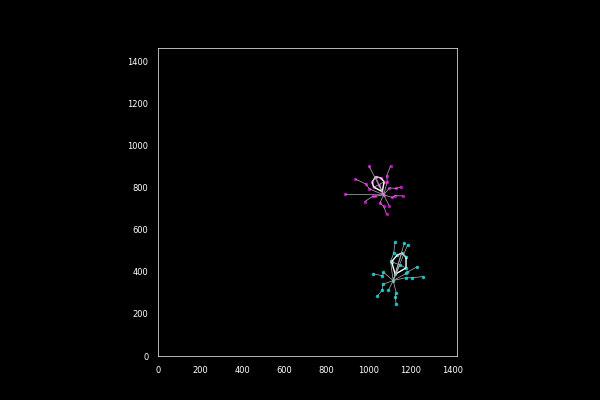

In [239]:
skeleton_color0 = [0.7]*3
markersize=3
skeleton_lw=0.5
lw=1

inds = inds_ab.copy()
fig, ax = pl.subplots()
bodyparts2plot = set(df0.columns.get_level_values("bodyparts"))
individuals = set(df0.columns.get_level_values("individuals"))
ix=50
for ind2plot in individuals:
    curr_col = animal_colors[ind2plot]
    df = df0.loc(axis=1)[:, ind2plot]
    for bpindex, bp in enumerate(bodyparts2plot):
        prob = df.xs(
            (bp, "likelihood"), level=(-2, -1), axis=1
        ).values.squeeze()
        mask = prob < pcutoff
        temp_x = np.ma.array(
            df.xs((bp, "x"), level=(-2, -1), axis=1).values.squeeze(),
            mask=mask,
        )
        temp_y = np.ma.array(
            df.xs((bp, "y"), level=(-2, -1), axis=1).values.squeeze(),
            mask=mask,
        )
        ax.plot(temp_x[ix], temp_y[ix], ".", color=curr_col, alpha=alphavalue, markersize=markersize)

    nx = int(np.nanmax(df.xs("x", axis=1, level="coords")))
    ny = int(np.nanmax(df.xs("y", axis=1, level="coords")))

    n_frames = df.shape[0]
    xyp = df.values.reshape((n_frames, -1, 3))
    coords = xyp[ix, :, :2]
    coords[xyp[ix, :, 2] < pcutoff] = np.nan
    segs = coords[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
    coll = mpl.collections.LineCollection(segs, colors=skeleton_color, alpha=alphavalue, lw=lw)
    # plot
    ax.add_collection(coll)
    
    segs0 = coords[tuple(zip(*tuple(inds_og))), :].swapaxes(0, 1) if inds_og else []
    col0 = mpl.collections.LineCollection(segs0, colors=skeleton_color0, alpha=alphavalue, lw=skeleton_lw)
    ax.add_collection(col0)
    # axes
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_aspect(1)

In [240]:
from shapely.geometry import Point, MultiPoint
# from shapely.geometry.polygon import Polygon

In [243]:
# abdomnen indices
# inds_ab = get_segment_indices(abdomen2connect, all_bpts)
# male/female IDs
male_id = 'ind1' # magenta | MALE
female_id = 'ind2' # cyan | FEMALE
df_m = df0.loc(axis=1)[:, male_id]
df_f = df0.loc(axis=1)[:, female_id]
n_frames = df_m.shape[0]

In [390]:
# get male's foreleg positions 
d_list = []
for leg_id in ['forlegLeft', 'forlegRight']:
    coords = df_m.xs(leg_id, level='bodyparts', axis=1).to_numpy() #[:, 0:]
    df_ = pd.DataFrame(data=coords, columns=['x', 'y', 'prob'], index=df_m.xs(leg_id, level='bodyparts', axis=1).index.tolist())
    df_['leg_id'] = 0 if leg_id=='forlegLeft' else 1
    d_list.append(df_)
legdf = pd.concat(d_list, axis=0)    

In [391]:
legdf.head()

,x,y,prob,leg_id
0,807.044,1073.133,1.000,0
1,806.071,1068.257,1.000,0
2,812.566,1068.153,0.998,0
3,812.565,1057.885,0.998,0
4,812.551,1057.775,0.999,0


In [393]:
# coords for female
xyp = df_f.values.reshape((n_frames, -1, 3))
d_list = []
for ix, df_ in legdf.iterrows():
    if df_['prob']>=pcutoff:
        # coords
        coords = xyp[ix, :, :2]
        # make polygon
        cc = coords[np.unique(inds), :]
        if not np.isnan(cc).any(): #cc.all():
            poly = dlc.polygon_from_coords(cc) #coords, inds_ab)
            # get foreleg pos
            point = Point(df_['x'], df_['y']) #[0], forleg_coords[1])
            is_inside = poly.contains(point)
            multiplier = -1 if is_inside else 1 # if inside, make negative for sorting
            d_ = pd.DataFrame({
                'distance': poly.exterior.distance(point) * multiplier,
                'is_inside': is_inside,
                'leg_id': df_['leg_id'],
                'frame': ix
            }, index=[ix])
            d_list.append(d_)
distdf = pd.concat(d_list).reset_index(drop=True)

/home/julianarhee/anaconda3/envs/pymov/lib/python3.8/site-packages/shapely/predicates.py:540: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)


<IPython.core.display.Javascript object>


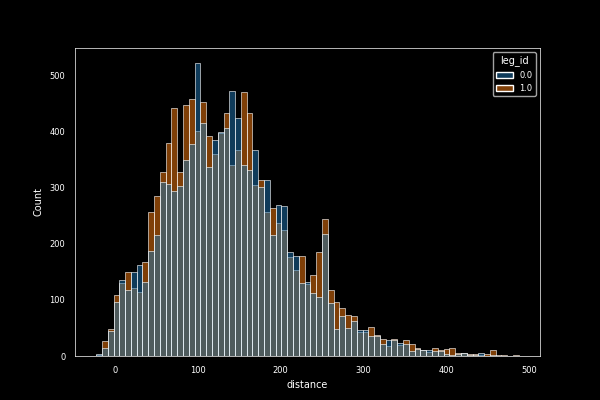

<Axes: xlabel='distance', ylabel='Count'>

In [394]:
fig, ax = pl.subplots()
sns.histplot(data=distdf, x='distance', hue='leg_id', ax=ax)

## plot putative taps

In [395]:
figdir = os.path.join(rootdir, 'figures')
figid = srcdir
print(figid)
if not os.path.exists(figdir):
    os.makedirs(figdir)

/mnt/minerva/courtship-free-behavior/maDLCv2/MMFv2/MF-20mm-cantons-RL


#### video frames

In [374]:
tap_thresh_lower, tap_thresh_upper

(8, 10)

In [403]:
taps.groupby('frame')['distance'].min()

frame
75       10.468289
77       10.131580
1829     11.120776
1888     11.291035
1889     10.522058
           ...    
12836    11.430821
13130    10.209549
13211    10.500967
13551    10.722178
13822    10.343436
Name: distance, Length: 69, dtype: float64

In [404]:
taps.loc[taps.groupby('frame')['distance'].idxmin()]

,distance,is_inside,leg_id,frame
13783,10.468289,False,1.0,75
73,10.131580,False,0.0,77
15362,11.120776,False,1.0,1829
1631,11.291035,False,0.0,1888
1632,10.522058,False,0.0,1889
...,...,...,...,...
25736,11.430821,False,1.0,12836
26010,10.209549,False,1.0,13130
26086,10.500967,False,1.0,13211
12451,10.722178,False,0.0,13551


In [408]:
#meta_fpath = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_cDLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_meta.pickle'
model_prefix = 'DLC_dlcrnetms5_'
scorer = df0.columns[0]
fbase = fn.split(model_prefix)[0]
movie_fmt = 'avi'
video_fpath = '{}.{}'.format(fbase, movie_fmt) #esults_fpath.replace('%s_el.h5' % scorer, '.mp4')
assert os.path.exists(video_fpath), "Could not find corresponding video: {}".format(video_fpath)
cap = cv2.VideoCapture(video_fpath)

#### threshold taps

In [428]:
#min_tap_dist=1
#taps = distdf[(distdf['distance']<=min_tap_dist) ].copy()
tap_thresh_upper = 15
tap_thresh_lower = 10
taps = distdf[(~distdf['is_inside']) 
              & (distdf['distance']<=tap_thresh_upper) & (distdf['distance']>=tap_thresh_lower)].copy()
closest_tap = taps.loc[taps.groupby('frame')['distance'].idxmin()]
sorted_taps = closest_tap.sort_values(by='distance', ascending=False)
print(sorted_taps.shape)
sorted_taps.head()

(185, 4)


,distance,is_inside,leg_id,frame
25745,14.995960,False,1.0,12845
8542,14.994139,False,0.0,9329
19060,14.994132,False,1.0,5787
19058,14.961326,False,1.0,5785
8560,14.953854,False,0.0,9347


#### plot

<IPython.core.display.Javascript object>


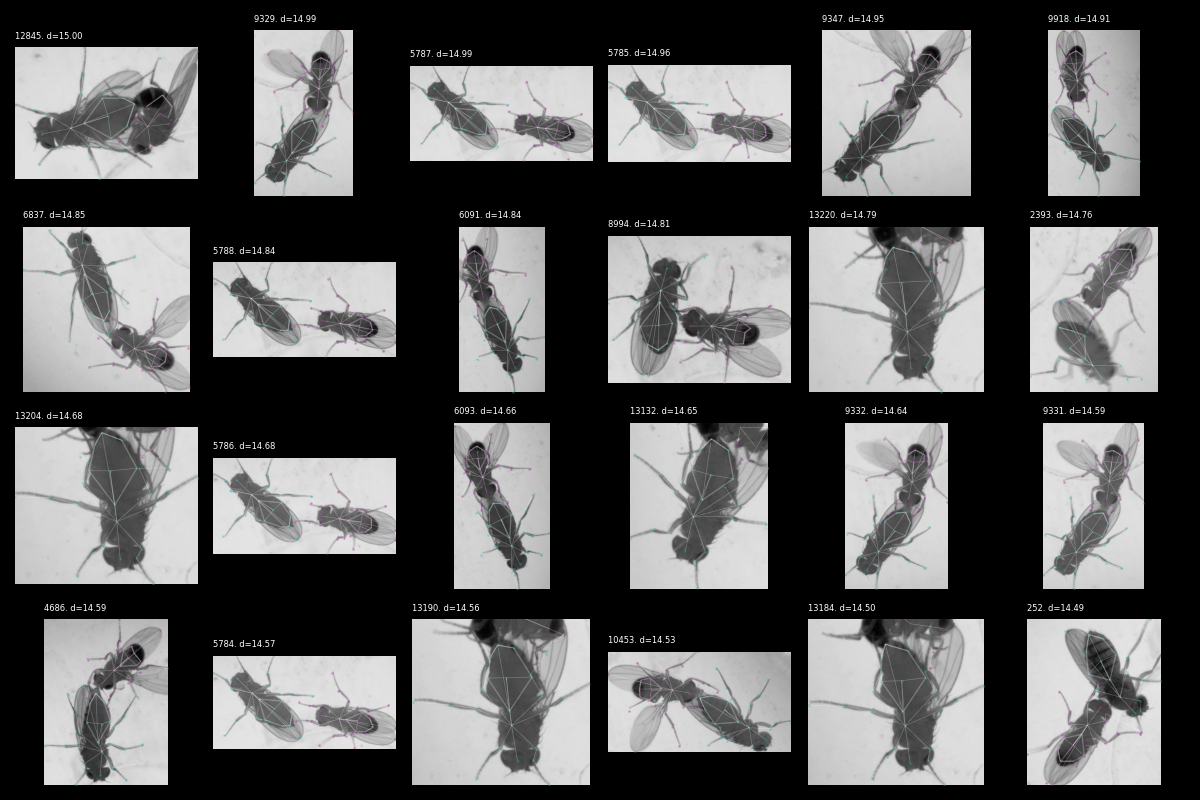

/mnt/minerva/courtship-free-behavior/maDLCv2/figures/outside-min-10-max-15-n24_frames.png


In [429]:
pcutoff=0.9 # keep this value HIGH, only include points that the network is confident about 
alphavalue=0.25
markersize=2

nr=4
nc=6
figname = 'outside-min-{}-max-{}-n{}'.format(tap_thresh_lower, tap_thresh_upper, nr*nc)

fig, axn = pl.subplots(nr, nc, figsize=(nc*2, nr*2))
for ai, (ix, df_) in enumerate(sorted_taps.iterrows()):
    frame_ix = df_['frame']
    if ai>=(nr*nc):
        break
    ax=axn.flat[ai]
    cap.set(1, frame_ix)
    ret, im = cap.read()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)
    ax.imshow(im, cmap='gray')
    # skeletons
    for ind2plot in individuals:
        currcol = animal_colors[ind2plot]
        df = df0.loc(axis=1)[:, ind2plot]
        # plot bodyparts
        putil.plot_bodyparts(df, frame_ix, bodyparts2plot, ax=ax, pcutoff=pcutoff,
                             color=currcol, alpha=alphavalue, markersize=markersize)
        # get current frame coords
        xyp = dlc.get_valid_coords(df, pcutoff=pcutoff)
        coords = xyp[frame_ix]
        # plot skeletons
        putil.plot_skeleton(coords, inds=inds_ab, ax=ax, color=skeleton_color, alpha=alphavalue, lw=lw)
        putil.plot_skeleton(coords, inds=inds_og, ax=ax, color=skeleton_color, alpha=alphavalue, lw=skeleton_lw)
    # axes
    nx = int(np.nanmax(df0.xs("x", axis=1, level="coords").loc[frame_ix]))
    ny = int(np.nanmax(df0.xs("y", axis=1, level="coords").loc[frame_ix]))
    nx_min = int(np.nanmin(df0.xs("x", axis=1, level="coords").loc[frame_ix]))
    ny_min = int(np.nanmin(df0.xs("y", axis=1, level="coords").loc[frame_ix]))
    ax.set_xlim(nx_min, nx)
    ax.set_ylim(ny_min, ny)
    ax.set_aspect(1)
    ax.axis('off')
    ax.set_title('{}. d={:.2f}'.format(frame_ix, df_['distance']), loc='left', fontsize=6)
pl.tight_layout()

figpath = os.path.join(figdir, '{}_frames.png'.format(figname))
pl.savefig(figpath) #curr_figid
print(figpath)

In [419]:
mm_per_pix = 20/1552
mm_per_pix*10

0.12886597938144329

In [ ]:
0.

<IPython.core.display.Javascript object>


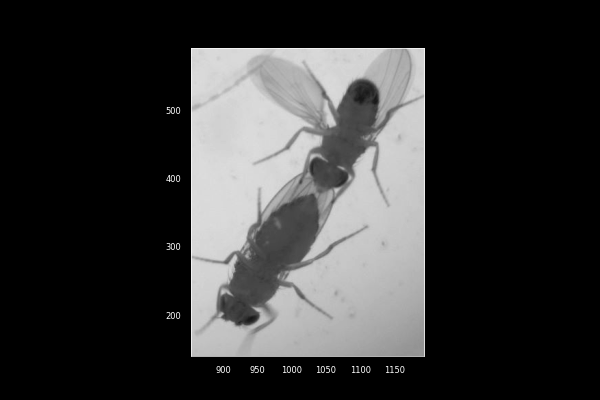

(140.0, 591.0)

In [422]:
frame_ix = 11522
#df0.loc(axis=1)[:, ind2plot]
fig, ax= pl.subplots()
cap.set(1, frame_ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)
ax.imshow(im, cmap='gray')

nx = int(np.nanmax(df0.xs("x", axis=1, level="coords").loc[frame_ix]))
ny = int(np.nanmax(df0.xs("y", axis=1, level="coords").loc[frame_ix]))
nx_min = int(np.nanmin(df0.xs("x", axis=1, level="coords").loc[frame_ix]))
ny_min = int(np.nanmin(df0.xs("y", axis=1, level="coords").loc[frame_ix]))
ax.set_xlim(nx_min, nx)
ax.set_ylim(ny_min, ny)

In [423]:
distdf[distdf['frame']==frame_ix]

,distance,is_inside,leg_id,frame
10596,19.726681,False,0.0,11522
24509,7.601876,False,1.0,11522


In [424]:
taps[taps['frame']==frame_ix]

,distance,is_inside,leg_id,frame
10596,19.726681,False,0.0,11522


In [140]:
df.dropna().shape, df.shape

((8458, 87), (15118, 87))

<IPython.core.display.Javascript object>


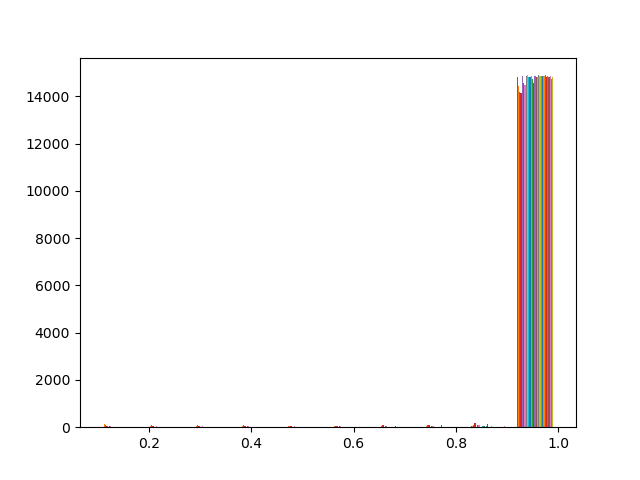

(array([[1.2000e+01, 4.0000e+00, 4.0000e+00, 5.0000e+00, 9.0000e+00,
         7.0000e+00, 1.4000e+01, 1.2000e+01, 3.5000e+01, 1.4809e+04],
        [1.1700e+02, 6.4000e+01, 5.0000e+01, 3.6000e+01, 4.5000e+01,
         4.4000e+01, 2.7000e+01, 3.7000e+01, 4.6000e+01, 1.4445e+04],
        [1.0700e+02, 8.1000e+01, 8.2000e+01, 7.2000e+01, 6.6000e+01,
         5.8000e+01, 6.8000e+01, 7.2000e+01, 1.0800e+02, 1.4197e+04],
        [7.0000e+01, 6.1000e+01, 5.8000e+01, 6.7000e+01, 7.0000e+01,
         6.4000e+01, 8.6000e+01, 1.0500e+02, 1.8700e+02, 1.4143e+04],
        [8.0000e+00, 8.0000e+00, 6.0000e+00, 2.0000e+00, 4.0000e+00,
         5.0000e+00, 7.0000e+00, 1.3000e+01, 1.0000e+01, 1.4848e+04],
        [3.0000e+01, 1.9000e+01, 2.0000e+01, 3.1000e+01, 2.9000e+01,
         3.3000e+01, 3.1000e+01, 5.6000e+01, 8.3000e+01, 1.4579e+04],
        [3.2000e+01, 3.3000e+01, 3.6000e+01, 4.2000e+01, 4.2000e+01,
         4.5000e+01, 4.5000e+01, 7.0000e+01, 8.7000e+01, 1.4479e+04],
        [5.0000e+00, 4.0000

In [142]:
df = df0.loc(axis=1)[:, ind2plot]
xyp = df.values.reshape((n_frames, -1, 3))

fig, ax =pl.subplots()
ax.hist(xyp[:, :, 2])

# DLC plotting for evaluation

In [124]:
def get_cmap(n, name="hsv"):
    """Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.
    https://github.com/DeepLabCut/DeepLabCut/blob/a61211dea445b664364c5befe5400dcbae9d577d/deeplabcut/utils/visualization.py#L33
    """
    return pl.cm.get_cmap(name, n)

def Histogram(vector, color, bins, ax=None, linewidth=1.0):
    '''
    https://github.com/DeepLabCut/DeepLabCut/blob/a61211dea445b664364c5befe5400dcbae9d577d/deeplabcut/utils/plotting.py#L48
    '''
    dvector = np.diff(vector)
    dvector = dvector[np.isfinite(dvector)]
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(dvector, color=color, histtype="step", bins=bins, linewidth=linewidth)

In [125]:
Dataframe = df0.copy()
individuals2plot = list(set(df0.columns.get_level_values("individuals")))
linewidth = 1.0

/tmp/ipykernel_2368129/955650131.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return pl.cm.get_cmap(name, n)


<IPython.core.display.Javascript object>


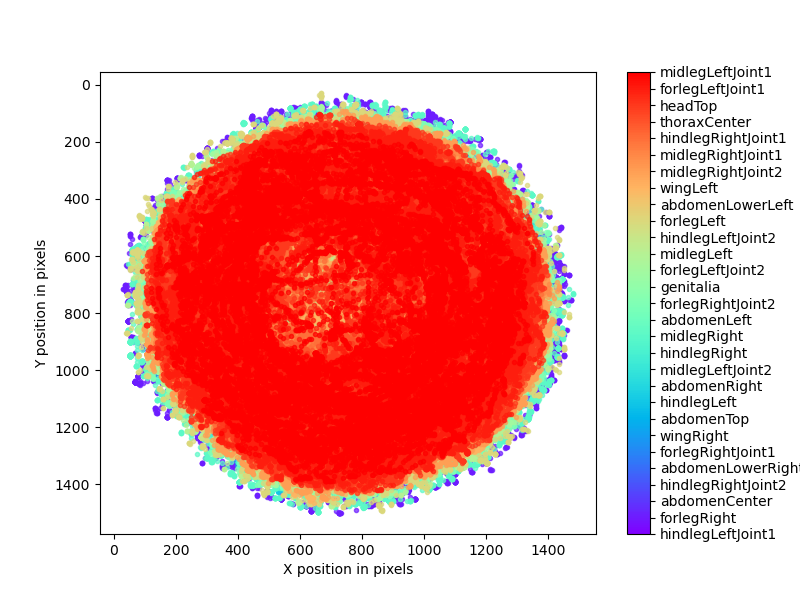

<IPython.core.display.Javascript object>


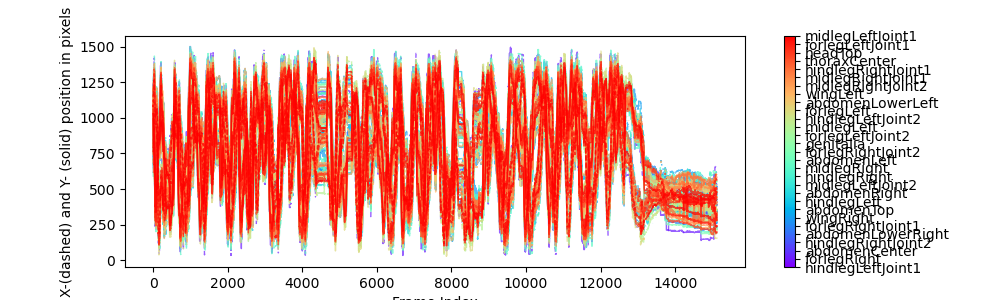

<IPython.core.display.Javascript object>


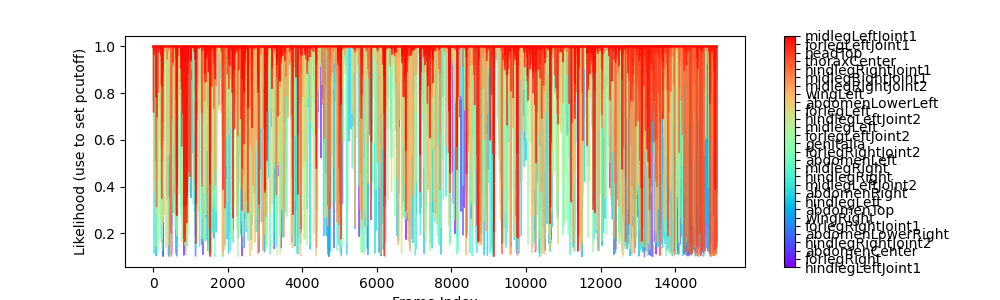

<IPython.core.display.Javascript object>


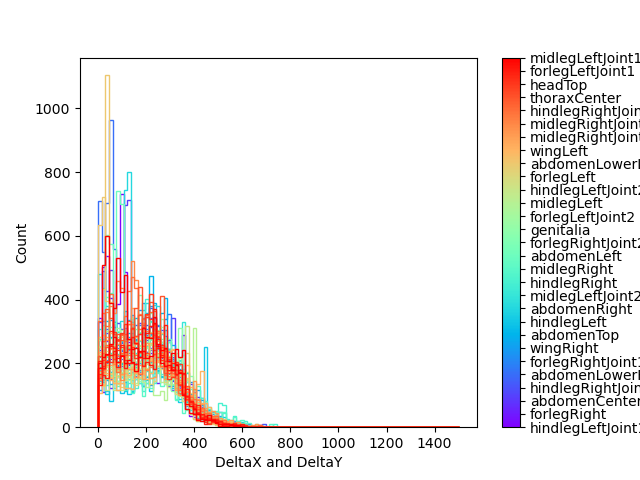

In [126]:
    """Plots poses vs time; pose x vs pose y; histogram of differences and likelihoods."""
    pcutoff = cfg["pcutoff"]
    colors = get_cmap(len(bodyparts2plot), name=cfg["colormap"])
    alphavalue = cfg["alphavalue"]
    if individuals2plot:
        Dataframe = Dataframe.loc(axis=1)[:, individuals2plot]
    animal_bpts = Dataframe.columns.get_level_values("bodyparts")
    # Pose X vs pose Y
    fig1 = pl.figure(figsize=(8, 6))
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel("X position in pixels")
    ax1.set_ylabel("Y position in pixels")
    ax1.invert_yaxis()

    # Poses vs time
    fig2 = pl.figure(figsize=(10, 3))
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel("Frame Index")
    ax2.set_ylabel("X-(dashed) and Y- (solid) position in pixels")

    # Likelihoods
    fig3 = pl.figure(figsize=(10, 3))
    ax3 = fig3.add_subplot(111)
    ax3.set_xlabel("Frame Index")
    ax3.set_ylabel("Likelihood (use to set pcutoff)")

    # Histograms
    fig4 = pl.figure()
    ax4 = fig4.add_subplot(111)
    ax4.set_ylabel("Count")
    ax4.set_xlabel("DeltaX and DeltaY")
    bins = np.linspace(0, np.amax(Dataframe.max()), 100)

    with np.errstate(invalid="ignore"):
        for bpindex, bp in enumerate(bodyparts2plot):
            if (
                bp in animal_bpts
            ):  # Avoid 'unique' bodyparts only present in the 'single' animal
                prob = Dataframe.xs(
                    (bp, "likelihood"), level=(-2, -1), axis=1
                ).values.squeeze()
                mask = prob < pcutoff
                temp_x = np.ma.array(
                    Dataframe.xs((bp, "x"), level=(-2, -1), axis=1).values.squeeze(),
                    mask=mask,
                )
                temp_y = np.ma.array(
                    Dataframe.xs((bp, "y"), level=(-2, -1), axis=1).values.squeeze(),
                    mask=mask,
                )
                ax1.plot(temp_x, temp_y, ".", color=colors(bpindex), alpha=alphavalue)

                ax2.plot(
                    temp_x,
                    "--",
                    color=colors(bpindex),
                    linewidth=linewidth,
                    alpha=alphavalue,
                )
                ax2.plot(
                    temp_y,
                    "-",
                    color=colors(bpindex),
                    linewidth=linewidth,
                    alpha=alphavalue,
                )

                ax3.plot(
                    prob,
                    "-",
                    color=colors(bpindex),
                    linewidth=linewidth,
                    alpha=alphavalue,
                )

                Histogram(temp_x, colors(bpindex), bins, ax4, linewidth=linewidth)
                Histogram(temp_y, colors(bpindex), bins, ax4, linewidth=linewidth)

    sm = pl.cm.ScalarMappable(
        cmap=pl.get_cmap(cfg["colormap"]),
        norm=pl.Normalize(vmin=0, vmax=len(bodyparts2plot) - 1),
    )
    sm._A = []
    for ax in ax1, ax2, ax3, ax4:
        cbar = pl.colorbar(sm, ax=ax, ticks=range(len(bodyparts2plot)))
        cbar.set_ticklabels(bodyparts2plot)


In [273]:
poly.contains(point)

False